# Diffusion Code in 100 Lines

In [1]:
import numpy as np
import copy
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from diffusers.models.unet_2d import UNet2DModel as Unet
from diffusers import DDPMScheduler
from tqdm import tqdm_notebook as tqdm
from IPython import display

### Dataset

In [4]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                               ])
# MNIST Dataset
train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16)
print(train_loader)

### Model Initialization

In [5]:
step = 0
# Unet Model
model = Unet(sample_size=32,
            in_channels=1,
            out_channels=1,
            center_input_sample=False,
            time_embedding_type="positional",
            down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D"),
            up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"),
            block_out_channels=(64, 128, 256, 512),
            layers_per_block=3).cuda()
# EMA Model
ema_model = copy.deepcopy(model)
ema_model = ema_model.cuda()
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# Diffusion Scheduler
scheduler = DDPMScheduler(num_train_timesteps=1000)
print('Model initialized.')

Model initialized.


### Train & Inference

  0%|          | 0/1000 [00:00<?, ?it/s]

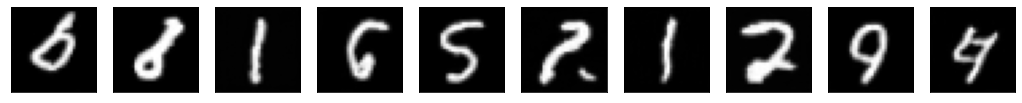

In [6]:
while True:
    for batch in train_loader:
        # Data Preparation
        x, _ = batch
        x = x * 2 - 1
        x = x.cuda()
        z = torch.randn_like(x)
        t = torch.randint(0, len(scheduler.betas), size=(len(x),)).cuda()
        x_noisy = scheduler.add_noise(x, z, t) 
        # Model Forward
        model.train()
        model.zero_grad()
        z_pred = model(x_noisy, t)['sample']
        loss = F.mse_loss(z_pred, z)  
        # Model Backward
        loss.backward()
        optimizer.step()
        # EMA Model Update
        model_state_dict = model.state_dict()
        ema_model_state_dict = ema_model.state_dict()
        for key in model_state_dict:
            ema_model_state_dict[key] = 0.999*ema_model_state_dict[key] + 0.001*model_state_dict[key]
        ema_model.load_state_dict(ema_model_state_dict)
        
        if step % 10 == 0:
            print('step :', step, 'loss :', loss.item())
        if step % 100 == 0:
            display.clear_output() 
        if step % 1000 == 0: 
            # Sampling    
            ema_model.eval()
            with torch.no_grad():
                x = torch.randn(10, 1, 32, 32).cuda()
                for t in tqdm(range(len(scheduler.betas)-1, -1, -1)):
                    t_tensor = torch.ones((len(x),)).cuda() * t
                    z_pred = ema_model(x, t_tensor)['sample']
                    x = scheduler.step(z_pred, t, x)['prev_sample']
               
            # Show Samples
            import matplotlib.pyplot as plt
            plt.figure(figsize=[18, 3])
            for i in range(10):
                plt.subplot(1, 10, i+1)
                plt.imshow(x[i, 0].data.cpu().numpy(), cmap='gray')
                plt.xticks([])
                plt.yticks([])
            plt.show()
                
        step += 1
        if step > 5000:
            break
            
    if step > 5000:        
        break